In [1]:
import pandas as pd
import numpy as np
from utils import (
    split_data, detect_categorical, fit_binning, create_iv_table,
    drop_high_vif, perform_feature_selection, train_model, train_regressor,
    evaluate_model, evaluate_regressor_model, save_model_artifacts
)

# Model data preparation

In [2]:
# --- Load Data ---
df_demog = pd.read_excel('Data/DataScientist_CaseStudy_Dataset.xlsx', sheet_name='Soc_Dem')
df_bal = pd.read_excel('Data/DataScientist_CaseStudy_Dataset.xlsx', sheet_name='Products_ActBalance')
df_in_out = pd.read_excel('Data/DataScientist_CaseStudy_Dataset.xlsx', sheet_name='Inflow_Outflow')
df_target = pd.read_excel('Data/DataScientist_CaseStudy_Dataset.xlsx', sheet_name='Sales_Revenues')
df_desc = pd.read_excel('Data/DataScientist_CaseStudy_Dataset.xlsx', sheet_name='Description')

# Data merge pipeline
df_master = (df_demog
             .merge(df_in_out, on='Client')
             .merge(df_bal, on='Client'))
df_master_label = df_master.merge(df_target, on='Client').fillna(0)

# Model feature engineering

In [3]:
# Adding feature engineering
df_master_label['Avg_CA_bal'] = df_master_label['ActBal_CA']/df_master_label['Count_CA']
df_master_label['Avg_SA_bal'] = df_master_label['ActBal_SA']/df_master_label['Count_SA']
df_master_label['Avg_MF_bal'] = df_master_label['ActBal_MF']/df_master_label['Count_MF']
df_master_label['utilization_CA'] = np.minimum(100,df_master_label['VolumeDeb_CA']/df_master_label['ActBal_CA'])

In [4]:
df_master_label['utilization_CA'].describe()

count    951.000000
mean      16.225776
std       32.414396
min        0.000000
25%        0.135818
50%        0.982017
75%        8.535650
max      100.000000
Name: utilization_CA, dtype: float64

# Model Training - Classification Models

Top IV variables:
                        Variable        IV
2                         Tenure  0.298206
1                            Age  0.269976
7                      VolumeDeb  0.154642
8                   VolumeDeb_CA  0.134161
29                    Avg_CA_bal  0.082223
11        VolumeDeb_PaymentOrder  0.081808
23                     ActBal_CA  0.081646
15  TransactionsDebCashless_Card  0.071065
14      TransactionsDebCash_Card  0.069225
10        VolumeDebCashless_Card  0.067692
32                utilization_CA  0.062826
9             VolumeDebCash_Card  0.060428
12               TransactionsDeb  0.048110
13            TransactionsDeb_CA  0.047862
4                  VolumeCred_CA  0.047279
24                     ActBal_SA  0.045200
3                     VolumeCred  0.043217
31                    Avg_MF_bal  0.034913
6            TransactionsCred_CA  0.034379
5               TransactionsCred  0.033856
19                      Count_MF  0.032041
30                    Avg_SA_bal  0.

C:\Users\joeytian\anaconda3\Lib\site-packages\optbinning\binning\transformations.py:38: RuntimeWarning: invalid value encountered in log
  return np.log((1. / event_rate - 1) * n_event / n_nonevent)
C:\Users\joeytian\anaconda3\Lib\site-packages\optbinning\binning\transformations.py:38: RuntimeWarning: invalid value encountered in log
  return np.log((1. / event_rate - 1) * n_event / n_nonevent)


✅ Final selected features: ['Age', 'Tenure', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder', 'Count_CA', 'ActBal_CA', 'ActBal_SA', 'ActBal_OVD', 'ActBal_CC', 'Avg_MF_bal']

🔍 Model Evaluation on Test Set
AUROC: 0.6731203007518797


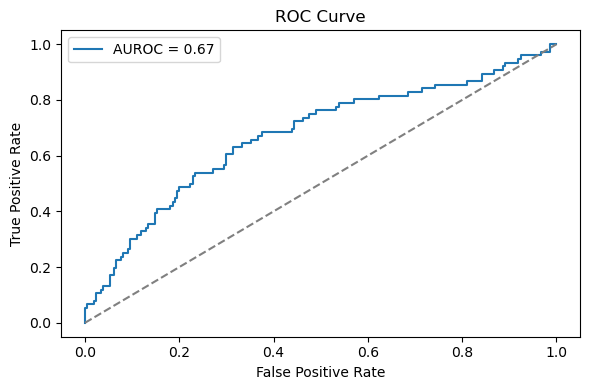

In [7]:
# --- Configuration ---
# manually change below flags to train the 3 seperate models
target_col = 'Sale_CL'
# target_col = 'Sale_CC'
# target_col = 'Sale_MF'

drop_cols = ['Client', 'Sale_CC', 'Sale_MF', 'Sale_CL', 'Revenue_MF', 'Revenue_CL', 'Revenue_CC']

# --- Split Data ---
X_train, X_test, y_train, y_test = split_data(df_master_label, target_col, drop_cols)

# --- Detect Categorical ---
categorical_vars = detect_categorical(X_train)

# --- Fit Binning ---
binning_process = fit_binning(X_train, y_train, categorical_vars)

# --- Create IV Table ---
iv_df = create_iv_table(X_train, binning_process, target_col)
print("Top IV variables:")
print(iv_df)

# --- WoE Transform ---
X_train_woe = binning_process.transform(X_train, metric="woe")
X_test_woe = binning_process.transform(X_test, metric="woe")

# --- VIF Reduction ---
X_train_vif = drop_high_vif(X_train_woe)
vif_selected_features = X_train_vif.columns.tolist()
X_test_vif = X_test_woe[vif_selected_features]

# --- Sequential Feature Selection ---
selected_features = perform_feature_selection(X_train_vif, y_train)
print("✅ Final selected features:", selected_features)

# --- Train Final Model ---
X_train_final = X_train_vif[selected_features]
X_test_final = X_test_vif[selected_features]
lr_final = train_model(X_train_final, y_train)

# --- Save Model & Metadata ---
save_model_artifacts(lr_final, binning_process, selected_features, target_col)

# --- Evaluate Model ---
evaluate_model(lr_final, X_test_final, y_test, target_col)


# Model Training - Regressor models

In [ ]:
# --- Configuration ---
# manually change below flags to train the 3 seperate models
# filter_col = 'Sale_CL'
# filter_col = 'Sale_CC'
filter_col = 'Sale_MF'
# target_col = 'Revenue_CL'
# target_col = 'Revenue_CC'
target_col = 'Revenue_MF'

drop_cols = ['Client', 'Sale_CC', 'Sale_MF', 'Sale_CL', 'Revenue_MF', 'Revenue_CL', 'Revenue_CC']

# --- Filter out customers who have revenue ---
df_master_label_filter = df_master_label[df_master_label[filter_col] > 0].copy()

# --- Split Data ---
X_train, X_test, y_train, y_test = split_data(df_master_label_filter, target_col, drop_cols)

# Convert categorical columns to 'category' dtype
X_train['Sex'] = X_train['Sex'].astype('category')
X_test['Sex'] = X_test['Sex'].astype('category')
# numeric_cols = X_train.select_dtypes(include=['number']).columns  # Select only numeric columns

# --- Remove outliers ---
# Calculate IQR for each feature
# Q1 = X_train[numeric_cols].quantile(0.25)  # 25th percentile (Q1)
# Q3 = X_train[numeric_cols].quantile(0.75)
# IQR = Q3 - Q1
#
# # Identify and remove outliers
# X_train_no_outliers = X_train[~((X_train[numeric_cols] < (Q1 - 1.5 * IQR)) | (X_train[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
# y_train_no_outliers = y_train[~((X_train[numeric_cols] < (Q1 - 1.5 * IQR)) | (X_train[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

# --- Train Regressor Model ---
xgb_final = train_regressor(X_train, y_train)

# --- Save Model & Metadata ---
save_model_artifacts(xgb_final, None, None, target_col)

# --- Evaluate Model ---
y_pred = xgb_final.predict(X_test)
evaluate_regressor_model(xgb_final, X_test, y_test, target_col)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


In [8]:
print(target_col)
y_pred.mean()

Revenue_MF


7.8262432617878614